In [1]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame
import numpy as np

In [2]:
## define  d1 and d2 in Black-Scholes model
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/sigma*sqrt(T)
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

## call options price function
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

## define the put options price function
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)-S+bs_call(S,K,T,r,sigma)

In [3]:
## Call_Greeks
def call_delta(S,K,T,r,sigma):
    return norm.cdf(d1(S,K,T,r,sigma))
def call_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def call_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def call_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) - r*K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))
def call_rho(S,K,T,r,sigma):
    return 0.01*(K*T*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)))

In [4]:
## Put_Greeks
def put_delta(S,K,T,r,sigma):
    return -norm.cdf(-d1(S,K,T,r,sigma))
def put_gamma(S,K,T,r,sigma):
    return norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))
def put_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))
def put_theta(S,K,T,r,sigma):
    return 0.01*(-(S*norm.pdf(d1(S,K,T,r,sigma))*sigma)/(2*sqrt(T)) + r*K*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))
def put_rho(S,K,T,r,sigma):
    return 0.01*(-K*T*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)))

In [5]:
S = 27.54            # Underlying price (per share): S; 
K = 28.75            # Strike price of the option (per share): K;
T = '22-02-2021'     # Time to maturity (years): T;
r = 2                # Continuously compounding risk-free interest rate: r;
sigma = 51           # Volatility: sigma;
 
S = float(S)
K = float(K)
T = datetime.strptime(T, "%d-%m-%Y")
T = (T - datetime.utcnow()).days / 365
r = float(r)
sigma = float(sigma)

In [6]:
## make a DataFrame of these inputs

data = {'Symbol': ['S', 'K', 'T', 'r', 'sigma'],
        'Input': [S, K, T , r , sigma]}
input_frame = DataFrame(data, columns=['Symbol', 'Input'], 
                   index=['Underlying price', 'Strike price', 'Time to maturity', 'Risk-free interest rate', 'Volatility'])
input_frame

,Symbol,Input
Underlying price,S,27.540000
Strike price,K,28.750000
Time to maturity,T,0.030137
Risk-free interest rate,r,2.000000
Volatility,sigma,51.000000


In [7]:
## calculate the call / put option price and the greeks of the call / put option
r = r/100; sigma = sigma/100;
price_and_greeks = {'Call' : [bs_call(S,K,T,r,sigma), call_delta(S,K,T,r,sigma), call_gamma(S,K,T,r,sigma),call_vega(S,K,T,r,sigma), call_rho(S,K,T,r,sigma), call_theta(S,K,T,r,sigma)],
                    'Put' : [bs_put(S,K,T,r,sigma), put_delta(S,K,T,r,sigma), put_gamma(S,K,T,r,sigma),put_vega(S,K,T,r,sigma), put_rho(S,K,T,r,sigma), put_theta(S,K,T,r,sigma)]}
price_and_greeks_frame = DataFrame(price_and_greeks, columns=['Call','Put'], index=['Price', 'delta', 'gamma','vega','rho','theta'])
price_and_greeks_frame

,Call,Put
Price,0.422755,1.615432
delta,0.494775,-0.505225
gamma,0.163602,0.163602
vega,0.019072,0.019072
rho,0.003979,-0.004680
theta,-0.164012,-0.158266


In [8]:
Price = 0.47 # Real price
option = 'C' # Option Type: C or P

In [9]:
def implied_volatility(Price,S,K,T,r):
    sigma = 0.001
    #print (np.array([['Price', 'S', 'K', 'T', 'r'], [Price, S, K, T, r]]))
    if option == 'C':
        while sigma < 1:
            Price_implied = S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
            if Price-(Price_implied) < 0.001:
                return sigma
            sigma += 0.001
        return "It could not find the right volatility of the call option."
    else:
        while sigma < 1:
            Price_implied = K*exp(-r*T)-S+bs_call(S,K,T,r,sigma)
            if Price-(Price_implied) < 0.001:
                return sigma
            sigma += 0.001
        return "It could not find the right volatility of the put option."
    return

print ("The implied volatility is " + str (100* implied_volatility(Price,S,K,T,r)) + " %.")

The implied volatility is 53.400000000000034 %.


Gain when price above: 29.172755318985367


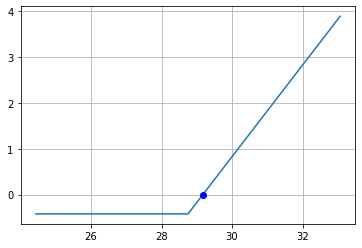

In [11]:
import matplotlib.pyplot as plt
f_price = np.arange(0.85*K, 1.15*K, K/100)

gain=[]
for f in f_price:
    if f > K:
        gain.append(f-K-bs_call(S,K,T,r,sigma))
    if f < K:
        gain.append(-bs_call(S,K,T,r,sigma))
plt.plot(f_price, gain)
plt.plot(K + bs_call(S,K,T,r,sigma), 0,'bo')
plt.grid(True)
print('Gain when price above:',K + bs_call(S,K,T,r,sigma))